# Semantic Search in arXiv Papers

This notebook shows how to retrieve data from the arXiv API and implement semantic search and recency weighting with Superlinked. More specifically, the notebook will include the following steps:

Preparation

- Retrieving, processing and exploring the data

Setting up our vector computer

-  Creating a schema
-  Creating vector embedding spaces
-  Indexing & parsing
-  Setting up & filling an in-memory data store

Searching

- Queries
- Weighting

## Preparation

In [1]:
%%capture
%pip install superlinked
%pip install lxml bs4

### Setting up a basic logger

In [2]:
import altair as alt
import logging
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime, timedelta, timezone
from urllib.parse import urlencode

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.context import CONTEXT_COMMON, CONTEXT_COMMON_NOW
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")

# Creating and configuring our logger
logging.basicConfig(filename="std.log", format="%(asctime)s %(message)s", filemode="w")
logger = logging.getLogger()

# Set the logger threshold to DEBUG if you encounter errors
logger.setLevel(logging.INFO)

## Fetching & processing data from the arXiv API

In [3]:
def query_arxiv(
    query="%22large%20language%20models%22",
    max_results=1000,
    order_by="lastUpdatedDate",
    order="descending",
):
    """
    Basic function for querying the api that lets us specify the most important parameters.

    query: URL encoded string to search for in paper titles and abstracts
    max_results: maximum amount of results returned by the api
    order_by: variable to order the results by
    order: descending or ascending based on the order_by parameter
    """
    params = {
        "search_query": f"all:{query}",
        "start": 0,
        "max_results": max_results,
        "sortBy": order_by,
        "sortOrder": order,
    }
    url = f"http://export.arxiv.org/api/query?{urlencode(params)}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        logging.info(f"Length of response text: {len(response.text)}")
        soup = BeautifulSoup(response.text, "xml")
        data = []

        for entry in soup.find_all("entry"):
            data_entry = {tag.name: tag.text.strip() for tag in entry.find_all()}
            if "id" in data_entry:  # Ensure there is an 'id' field
                data.append(data_entry)

        logging.info(f"{len(data)} entries found")
        return pd.DataFrame(data)

    except requests.exceptions.RequestException as e:
        logging.error(f"Error during request: {e}")
    except Exception as e:
        logging.error(f"Unexpected error: {e}")

    return pd.DataFrame()  # Return an empty DataFrame if there was an error

In [4]:
# We are using URL encodings here: %22 means "" and %20 stands for a space
df = query_arxiv(query="%22retrieval%20augmented%20generation%22")

In [5]:
# Notice that we set the maximum to 1000 but the api returned less results, meaning
# that the number of paper titles and abstracts including our search query is below 1000
len(df)

360

## Exploring & preparing the data

In [6]:
# Checking all columns
df.columns

Index(['id', 'updated', 'published', 'title', 'summary', 'author', 'name',
       'comment', 'link', 'primary_category', 'category', 'journal_ref', 'doi',
       'affiliation'],
      dtype='object')

In [7]:
# Feel free to play around more with the data if you want,
# but for this application, we will only need a few columns
df = df[["id", "published", "title", "summary"]].copy()

In [8]:
df.head(3)

,id,published,title,summary
0,http://arxiv.org/abs/2405.12750v1,2024-05-21T13:02:27Z,Generative AI and Large Language Models for Cy...,This paper provides a comprehensive review of ...
1,http://arxiv.org/abs/2402.14776v2,2024-02-22T18:35:05Z,ESE: Espresso Sentence Embeddings,High-quality sentence embeddings are fundament...
2,http://arxiv.org/abs/2405.12363v1,2024-05-20T20:27:00Z,Question-Based Retrieval using Atomic Units fo...,Enterprise retrieval augmented generation (RAG...


In [9]:
# Renaming the columns to have more intuitive names
df = df.reset_index().rename(
    columns={"id": "url", "index": "id", "summary": "abstract"}
)

In [10]:
# The api returns the datetimes as a string, which we first parse
# in the datetime format and then convert them to timestamps
df["published_timestamp"] = [
    parser.parse(date).replace(tzinfo=timezone.utc).timestamp() for date in df.published
]

## Visualizing the timestamps

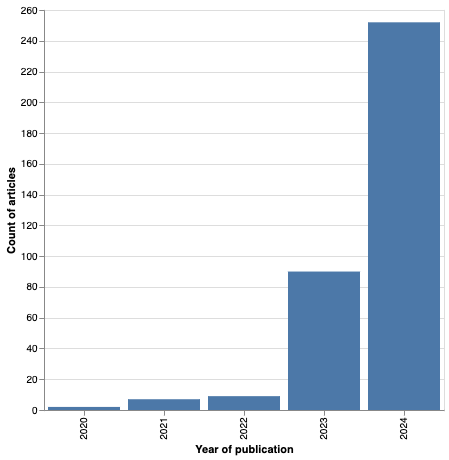

In [11]:
# some quick transformations and an altair histogram
years_to_plot: pd.DataFrame = pd.DataFrame(
    {
        "year_of_publication": [
            int(datetime.fromtimestamp(ts).year) for ts in df["published_timestamp"]
        ]
    }
)
alt.Chart(years_to_plot).mark_bar().encode(
    alt.X("year_of_publication:N", title="Year of publication"),
    y=alt.Y("count()", title="Count of articles"),
).properties(width=400, height=400)

## Setting up Superlinked

In [12]:
# Setting up the schema according to our inputs
@schema
class PapersSchema:
    url: String
    title: String
    abstract: String
    published_timestamp: Timestamp
    id: IdField


papers = PapersSchema()

In [13]:
YEAR_IN_DAYS = 365

# Textual characteristics are embedded using a sentence-transformers model
abstract_space = TextSimilaritySpace(
    text=papers.abstract, model="sentence-transformers/all-mpnet-base-v2"
)
title_space = TextSimilaritySpace(
    text=papers.title, model="sentence-transformers/all-mpnet-base-v2"
)
# Release date is encoded using Superlinked's recency embedding algorithm
recency_space = RecencySpace(
    timestamp=papers.published_timestamp,
    period_time_list=[
        PeriodTime(timedelta(days=4 * YEAR_IN_DAYS), weight=1),
        PeriodTime(timedelta(days=11 * YEAR_IN_DAYS), weight=2),
    ],
    negative_filter=0.0,
)

In [14]:
# We create an index of our spaces
papers_index = Index(spaces=[abstract_space, title_space, recency_space])

In [15]:
dataframe_parser = DataFrameParser(
    schema=papers,
    mapping={
        papers.published_timestamp: "published_timestamp",
        papers.abstract: "abstract",
    },
)

In [16]:
# Setting a specific end date to ensure reproducibility of the notebook
END_OF_APRIL_24_TS = int(datetime(2024, 4, 30, 23, 59).timestamp())
EXECUTOR_DATA = {CONTEXT_COMMON: {CONTEXT_COMMON_NOW: END_OF_APRIL_24_TS}}

source: InMemorySource = InMemorySource(papers, parser=dataframe_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source], indices=[papers_index], context_data=EXECUTOR_DATA
)
app: InMemoryApp = executor.run()

In [17]:
# IMPORTANT: if you're running this notebook in Google Colab and
# this step is taking very long - you might be running an instance without a GPU
source.put([df])

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

## Understanding recency

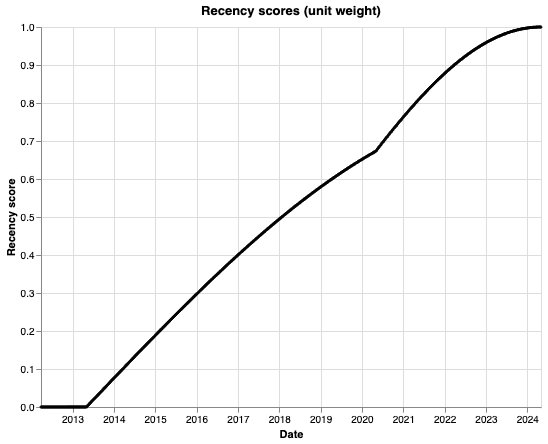

In [18]:
# To get an intuitive understanding of how recency is weighted for our data,
# we can explore the weights using Superlinked's inbuilt RecencyPlotter
recency_plotter = RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
recency_plotter.plot_recency_curve()

## Defining queries

In [19]:
TOP_N = 10

# A simple query will serve us right when we simply want to search the dataset with a search term
# the term will search in both textual fields
# and we will have the option to weight certain inputs' importance
simple_query = (
    Query(
        papers_index,
        weights={
            abstract_space: Param("abstract_weight"),
            title_space: Param("title_weight"),
            recency_space: Param("recency_weight"),
        },
    )
    .find(papers)
    .similar(abstract_space.text, Param("query_text"))
    .similar(title_space.text, Param("query_text"))
    .limit(TOP_N)
)

In [20]:
# A quick helper to present the results in a notebook
def present_result(
    result: Result,
    cols_to_keep: list[str] = ["abstract", "title", "release_date", "id"],
) -> pd.DataFrame:
    # Parse result to dataframe
    df: pd.DataFrame = pd.DataFrame([entry.stored_object for entry in result.entries])
    # Transform timestamp back to release year, Ts is in milliseconds originally hence the division
    df["release_date"] = [
        datetime.fromtimestamp(timestamp, tz=timezone.utc).date()
        for timestamp in df["published_timestamp"]
    ]
    return df[cols_to_keep]

## Executing the queries

In [21]:
regular_result = app.query(
    simple_query,
    query_text="cost reduction",
    abstract_weight=1,
    title_weight=1,
    recency_weight=0,
)

present_result(regular_result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,abstract,title,release_date,id
0,By integrating Artificial Intelligence (AI) wi...,Generative AI for Low-Carbon Artificial Intell...,2024-04-28,56
1,"In this paper, we explore the potential applic...",Automated Conversion of Static to Dynamic Sche...,2024-05-08,31
2,Design/methodology/approach This research eval...,Graph database while computationally efficient...,2024-01-15,275
3,Standard Full-Data classifiers in NLP demand t...,Making LLMs Worth Every Penny: Resource-Limite...,2023-11-10,315
4,There is a compelling necessity from enterpris...,Fine Tuning LLM for Enterprise: Practical Guid...,2024-03-23,151
5,The task of converting natural language querie...,DFIN-SQL: Integrating Focused Schema with DIN-...,2024-03-01,191
6,The interest in updating Large Language Models...,LLMs Instruct LLMs:An Extraction and Editing M...,2024-03-23,152
7,"In customer service technical support, swiftly...",Retrieval-Augmented Generation with Knowledge ...,2024-04-26,37
8,In the rapidly evolving field of assistive tec...,Towards Standards-Compliant Assistive Technolo...,2024-04-04,126
9,ESGReveal is an innovative method proposed for...,ESGReveal: An LLM-based approach for extractin...,2023-12-25,291


In [22]:
recency_weighted_result = app.query(
    simple_query,
    query_text="cost reduction",
    abstract_weight=1,
    title_weight=1,
    recency_weight=1,
)

present_result(recency_weighted_result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,abstract,title,release_date,id
0,By integrating Artificial Intelligence (AI) wi...,Generative AI for Low-Carbon Artificial Intell...,2024-04-28,56
1,"In this paper, we explore the potential applic...",Automated Conversion of Static to Dynamic Sche...,2024-05-08,31
2,Design/methodology/approach This research eval...,Graph database while computationally efficient...,2024-01-15,275
3,There is a compelling necessity from enterpris...,Fine Tuning LLM for Enterprise: Practical Guid...,2024-03-23,151
4,The task of converting natural language querie...,DFIN-SQL: Integrating Focused Schema with DIN-...,2024-03-01,191
5,Standard Full-Data classifiers in NLP demand t...,Making LLMs Worth Every Penny: Resource-Limite...,2023-11-10,315
6,The interest in updating Large Language Models...,LLMs Instruct LLMs:An Extraction and Editing M...,2024-03-23,152
7,"In customer service technical support, swiftly...",Retrieval-Augmented Generation with Knowledge ...,2024-04-26,37
8,In the rapidly evolving field of assistive tec...,Towards Standards-Compliant Assistive Technolo...,2024-04-04,126
9,ESGReveal is an innovative method proposed for...,ESGReveal: An LLM-based approach for extractin...,2023-12-25,291


In [23]:
# A quick helper to visualize the effect of recency weighting
def get_time_differences(
    result: Result,
    alternative_result: Result,
    cols_to_keep: list[str] = ["abstract", "title", "release_date", "id"],
) -> pd.DataFrame:
    # Getting the timestamps of both results
    result_ts = [entry.stored_object["published_timestamp"] for entry in result.entries]
    alternative_result_ts = [
        entry.stored_object["published_timestamp"]
        for entry in alternative_result.entries
    ]
    # Calculating the absolute time difference in seconds
    time_diff = list(np.absolute(np.array(result_ts) - np.array(alternative_result_ts)))
    # Rounded time difference in days
    time_diff_days = [round(t_d / 3600 / 24, 1) for t_d in time_diff]
    return time_diff_days

In [24]:
get_time_differences(regular_result, recency_weighted_result)

[0.0, 0.0, 0.0, 133.9, 22.3, 111.7, 0.0, 0.0, 0.0, 0.0]

You will see that a lot of the positions haven’t changed, but some have!

Obviously, this was a pretty basic example. But I hope I was able to make clear why recency can be an important factor. We could’ve also filtered our timestamp data - metadata filtering is a common practice in Advanced RAG systems after all. However, the recency embeddings we used here are generally more nuanced, similar to how text embeddings are more nuanced than regex.

Which one will work better for you will depend on your specific use case. It’s important to remember that there are no silver bullets!